In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder
from torchvision import models

# 画像をテンソルに変換
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
}

# 画像データセットを読み込む
full_dataset = ImageFolder(root='/Users/serenakurashina/ess4-3/Cable1_Dataset')

# ハードウェアの設定 
device = torch.device('mps')

# データセットの分割
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# 各データセットのtransformを設定
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# DataLoader の定義
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ResNet18モデルを事前学習済みでインポート
model = models.resnet18(pretrained=True)

# 最後の全結合層を置き換え（5クラス分類に変更）
model.fc = nn.Linear(model.fc.in_features, 5)

# パラメータの更新を行う部分を定義（全層ではなく、最後の層だけを学習させる）
for param in model.parameters():
    param.requires_grad = False  # すべての層のパラメータを凍結

# 最後の層（fc）のみ学習可能にする
for param in model.fc.parameters():
    param.requires_grad = True

# モデルをデバイスに転送
model = model.to(device)

# 多クラス分類のための損失関数を定義
criterion = nn.CrossEntropyLoss()

# モデルのパラメータを更新するための最適化手法をAdamで定義
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# モデルの学習
EPOCHS = 10
train_loss_list = []  # 訓練データの損失リスト
val_loss_list = []    # 検証データの損失リスト
train_acc_list = []   # 訓練データの精度リスト
val_acc_list = []     # 検証データの精度リスト

for epoch in range(EPOCHS):
    model.train()  # モデルを学習モードに設定
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # データをデバイスに転送
        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(images)  # モデルの出力を取得
        loss = criterion(outputs, labels)  # 損失を計算

        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新

        train_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）
        
        # 正解数を計算
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total  # データ数で割って平均を取る
    train_accuracy = 100 * train_correct / train_total  # 訓練データの精度計算
    train_loss_list.append(train_loss)  # 訓練損失をリストに追加
    train_acc_list.append(train_accuracy)  # 訓練精度をリストに追加

    model.eval()  # モデルを評価モードに設定
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # 評価時は勾配を計算しない
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # データをデバイスに転送

            outputs = model(images)  # モデルの出力を取得
            loss = criterion(outputs, labels)  # 損失を計算

            val_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）

            # 正解数を計算
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total  # データ数で割って平均を取る
    val_accuracy = 100 * val_correct / val_total  # 検証データの精度計算
    val_loss_list.append(val_loss)  # 検証損失をリストに追加
    val_acc_list.append(val_accuracy)  # 検証精度をリストに追加

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# 検証の最後に学習済みモデルを保存
torch.save(model.state_dict(), "resnet18_kadai5.pth")


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 1.3164, Train Acc: 44.29%, Val Loss: 0.8150, Val Acc: 60.00%
Epoch 2/10, Train Loss: 0.7678, Train Acc: 55.71%, Val Loss: 0.6653, Val Acc: 63.33%
Epoch 3/10, Train Loss: 0.6595, Train Acc: 62.86%, Val Loss: 0.6455, Val Acc: 66.67%
Epoch 4/10, Train Loss: 0.6239, Train Acc: 65.00%, Val Loss: 0.6165, Val Acc: 70.00%
Epoch 5/10, Train Loss: 0.5519, Train Acc: 72.86%, Val Loss: 0.5752, Val Acc: 73.33%
Epoch 6/10, Train Loss: 0.5208, Train Acc: 77.86%, Val Loss: 0.5608, Val Acc: 73.33%
Epoch 7/10, Train Loss: 0.4872, Train Acc: 81.43%, Val Loss: 0.5614, Val Acc: 76.67%
Epoch 8/10, Train Loss: 0.4497, Train Acc: 86.43%, Val Loss: 0.5677, Val Acc: 73.33%
Epoch 9/10, Train Loss: 0.4211, Train Acc: 86.43%, Val Loss: 0.5455, Val Acc: 76.67%
Epoch 10/10, Train Loss: 0.3973, Train Acc: 89.29%, Val Loss: 0.5060, Val Acc: 80.00%


Confusion Matrix:
[[11  3]
 [ 3 13]]


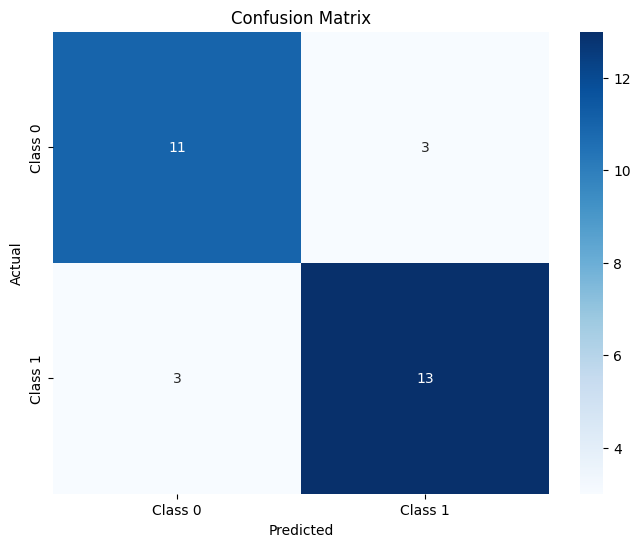

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79        14
     Class 1       0.81      0.81      0.81        16

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.80      0.80      0.80        30



In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 検証データでの推論
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader: 検証データのDataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# クラス名とラベルを一致させる
unique_labels = sorted(set(all_labels))  # 出現するクラスラベルを取得
if 'class_names' not in globals() or len(class_names) != len(unique_labels):
    class_names = [f"Class {i}" for i in unique_labels]  # 自動生成（例: "Class 0", "Class 1", ...）

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1スコアのレポート
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)

In [3]:
# モデルの評価
model.eval() # モデルを評価モードに設定
correct = 0 # 正解数
total = 0 # テストデータの総数
with torch.no_grad():
    for images, labels in test_loader: # テストデータを取得
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        outputs = model(images) # 画像をモデルに入力して出力を取得
        _, predicted = torch.max(outputs, 1) # 確率が最大のラベルを取得=モデルによる予測結果を取得
        total += labels.size(0) # labels.size(0)はミニバッチサイズ、毎回加算することでテストデータの総数を計算
        correct += (predicted == labels).sum().item() # 予測と正解ラベルが一致した場合に正解数をカウント
# 正解率を%で表示
print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 80.00%
